In [1]:
# run this is nothing in results_folder

# ! mkdir results_folder

# ! python train.py "data/Cambridge_KingsCollege/train/rgb/*.png" results_folder/ace_network.pt --pose_files "data/Cambridge_KingsCollege/train/poses/*.txt"  --pose_refinement none --use_external_focal_length 740 --refine_calibration False --use_aug False --patch_threshold 0.1

# ! python export_point_cloud.py  results_folder/point_cloud_out.txt --network results_folder/ace_network.pt  --pose_file results_folder/poses_ace_network_preliminary.txt

# 3D Scene Coordinate Prediction and Pose Estimation Demo

This demo showcases how to use a pre-trained neural network to predict scene coordinates and estimate camera pose using the DSAC\* algorithm. We will load point cloud data, process an image, perform inference, and visualize the results.


In [2]:
import torch
from torch.cuda.amp import autocast
from vis_3d import init_figure, plot_points, plot_camera
from ace_pose.network import Regressor
from ace_pose.dataset import CamLocDataset
import numpy as np
import dsacstar
from PIL import Image
from matplotlib import pyplot as plt


### Load Point Cloud Data

First, we load the previously generated point cloud data

In [3]:
# Load point cloud data
point_cloud_3d = np.loadtxt("results_folder/point_cloud_out.txt")
# Not too mush for vis.
random_indices = np.random.choice(point_cloud_3d.shape[0], 10000, replace=False)
point_cloud_3d = point_cloud_3d[random_indices, :]
pc_xyz = point_cloud_3d[..., :3]

# Convert from OpenGL coordinate system to OpenCV coordinate system
pc_xyz[:, 1] = -pc_xyz[:, 1]
pc_xyz[:, 2] = -pc_xyz[:, 2]

# Color information
pc_color = point_cloud_3d[..., 3:]


### Load and Preprocess Image

We load the test image from the dataset and perform necessary preprocessing, such as resizing and setting intrinsic parameters.


In [4]:
# Image path
queue_image_path = "data/Cambridge_GreatCourt/test/rgb/seq1_frame00564.png"
gt_pose_path = "data/Cambridge_GreatCourt/test/poses/seq1_frame00564.txt"
gt_pose = np.loadtxt(gt_pose_path)

# Create test dataset
test_dataset = CamLocDataset(queue_image_path, image_short_size=480)
test_dataset.set_external_focal_length(740)

# Retrieve data
image_1HW, _, _, _, intrinsics_33, _, _, filename, indice = test_dataset[0]

# Open original image
image_rgb = Image.open(queue_image_path)

# Get original size
original_size = image_rgb.size
width, height = original_size

# Resize image
new_size = (width // 8, height // 8)
resized_image_rgb = np.asarray(image_rgb.resize(new_size))


### Load Pre-trained Network Models

We load the pre-trained weights for the encoder and head networks, and set up the model for evaluation.


In [5]:
# Network weight paths
encoder_path = "xfeat.pt"
head_network_path = "results_folder/ace_network.pt"

# Load network weights
encoder_state_dict = torch.load(encoder_path, map_location="cpu")
head_state_dict = torch.load(head_network_path, map_location="cpu")

# Create regressor
network = Regressor.create_from_split_state_dict(encoder_state_dict, head_state_dict)

# Move to GPU and set to evaluation mode
network = network.to('cuda')
network.eval()

# Disable gradient computation and move image to GPU
with torch.no_grad():
    image_1HW = image_1HW.to('cuda', non_blocking=True)


### Predict Scene Coordinates

Using the neural network, we perform inference on the input image to predict 3D scene coordinates.


In [6]:
with torch.no_grad():
    # Perform inference with automatic mixed precision
    with autocast(enabled=True):
        scene_coordinates_3HW = network(image_1HW.unsqueeze(0))[0]
        _, heatmap_1HW = network.get_features(image_1HW.unsqueeze(0))
    # Move to CPU and convert to float
    scene_coordinates_3HW = scene_coordinates_3HW.float().cpu()
    
    # Extract intrinsic parameters
    focal_length = intrinsics_33[0, 0].item()
    ppX = intrinsics_33[0, 2].item()
    ppY = intrinsics_33[1, 2].item()


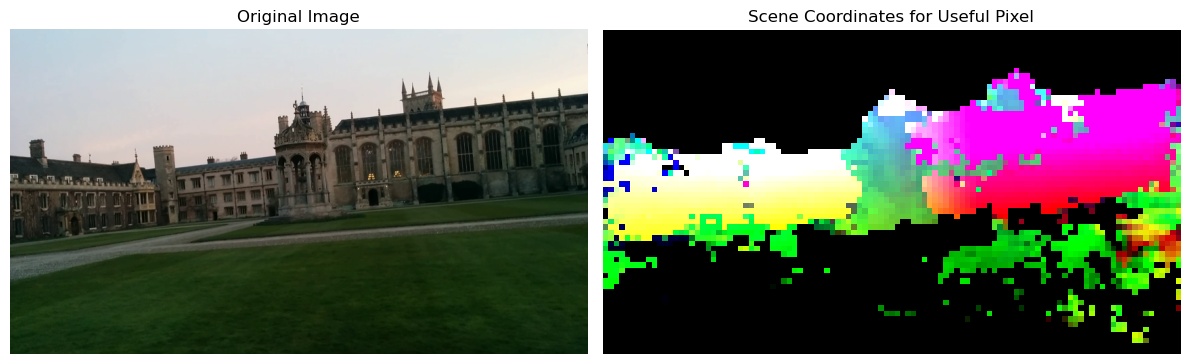

In [7]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Convert scene coordinates to NumPy array
sc_np = scene_coordinates_3HW.permute(1, 2, 0).numpy()
heatmap_np = heatmap_1HW[0, 0].cpu().numpy()

normalized_sc = np.zeros_like(sc_np)

# Normalize each channel separately
for i in range(3):
    lower = np.percentile(sc_np[:, :, i], 25)
    upper = np.percentile(sc_np[:, :, i], 75)
    temp = (sc_np[:, :, i] - lower) / (upper - lower)
    temp[heatmap_np < 0.1] = 0
    normalized_sc[:, :, i] = temp

# Clip values to keep them in the range [0, 1]
normalized_sc = np.clip(normalized_sc, 0, 1)

# Display original image
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display normalized scene coordinates
axes[1].imshow(normalized_sc)
axes[1].set_title("Scene Coordinates for Useful Pixel")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Estimate Pose Using DSAC\*

We use the DSAC\* algorithm to compute the camera pose based on the predicted scene coordinates.


In [8]:
# Initialize output pose matrix
out_pose = torch.zeros((4, 4))

# Estimate pose using DSAC*
inlier_map = dsacstar.forward_rgb(
    scene_coordinates_3HW.unsqueeze(0),
    out_pose,
    128,                    # Maximum iterations
    5,                    # Inlier threshold
    focal_length,
    ppX,
    ppY,
    100,                   # RANSAC threshold
    100,                   # RANSAC max iterations
    network.OUTPUT_SUBSAMPLE,
    42                   # Random seed
)

Sampling 128 hypotheses.
Done in 0.00335854s.
Calculating scores.
Done in 0.0102813s.
Drawing final hypothesis.
Soft inlier count: 6.7984 (Selection Probability: 48%)
Entropy of hypothesis distribution: 2.63049
Done in 4.4847e-05s.
Refining winning pose:
Done in 0.00909258s.


### 3D Visualization

Visualize the scene coordinates, camera pose, and point cloud data in a 3D plot.

You may need to use your mouse to adjust the perspective to see everything clearly.

The red dots show the queue image scene coordinates used for PnP.

Red camera is the queue pose.

Green camera is the ground-truth pose.


In [ ]:
# Initialize 3D figure
fig = init_figure()

# Plot original point cloud
plot_points(fig, pc_xyz, pc_color, name='Training Set Point Cloud')

inlier_sc_3I = scene_coordinates_3HW.view(3, -1)[:, inlier_map.flatten().bool()]
resized_image_rgb.reshape((-1, 3))
# Plot predicted scene coordinates with corresponding colors
plot_points(fig, inlier_sc_3I.permute(1, 0).numpy(), name='Queue Image Scene Coordinates')

# Plot camera pose
plot_camera(
    fig, 
    R=out_pose[:3, :3].numpy(), 
    t=out_pose[:3, 3].numpy(), 
    K=intrinsics_33.numpy(), 
    color='rgb(255, 0, 0)', 
    size=20, 
    text='predicted_pose'
)

plot_camera(
    fig, 
    R=gt_pose[:3, :3], 
    t=gt_pose[:3, 3], 
    K=intrinsics_33.numpy(), 
    color='rgb(0, 255, 0)', 
    size=20, 
    text='gt_pose'
)
# Display the figure
fig.show()
